In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


**Importing the libraries**

In [2]:
#GPU Libraries
import cudf as pd
import cupy as cp
import cuml
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.naive_bayes import MultinomialNB
from cuml.svm import SVC
from cuml.linear_model import LogisticRegression
from cuml.multiclass import MulticlassClassifier
from cuml.multiclass import OneVsRestClassifier


#Graph Plotting and Visualisation Library
import matplotlib.pyplot as plt
import seaborn as sns


#Text Preprocessing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import re
import string

#Deep Learning Libraries
import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential




**Reading the dataset**

In [3]:
train_df=pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',sep='\t')
test_df=pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep='\t')

In [4]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
train_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   PhraseId    156060 non-null  int64
 1   SentenceId  156060 non-null  int64
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64
dtypes: int64(3), object(1)
memory usage: 10.2+ MB


In [6]:
train_df.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [7]:
train_df.shape

(156060, 4)

In [8]:
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [9]:
test_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   PhraseId    66292 non-null  int64
 1   SentenceId  66292 non-null  int64
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [10]:
test_df.describe()

,PhraseId,SentenceId
count,66292.00000,66292.000000
mean,189206.50000,10114.909144
std,19136.99636,966.787807
min,156061.00000,8545.000000
25%,172633.75000,9266.000000
50%,189206.50000,10086.000000
75%,205779.25000,10941.000000
max,222352.00000,11855.000000


In [11]:
test_df.shape

(66292, 3)

**DATA PREPROCESSING**

In [12]:
#Checking the sum of null values in the train and test dataset
train_df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: uint64

In [13]:
test_df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
dtype: uint64

In [14]:
train_df.isnull().any().any()

False

In [15]:
test_df.isnull().any().any()

False

There are no null values in the dataset

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [16]:
train_df['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int32

We see that label-2 which is the neutral label, has the highest number of examples

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

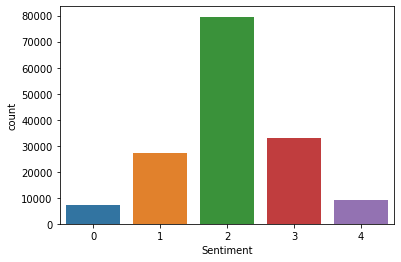

In [17]:
train=train_df.to_pandas()
sns.countplot(x ='Sentiment', data = train)

In [18]:
train_df['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

**Text Preprocessing**

Steps-

1) Remove Punctuations

2) Remove HTML Tags

3) Convert text to lowercase

4) Remove all special characters 

5) Remove stopwords

6) Perform Stemming

7) Join back after stemming

<AxesSubplot:>

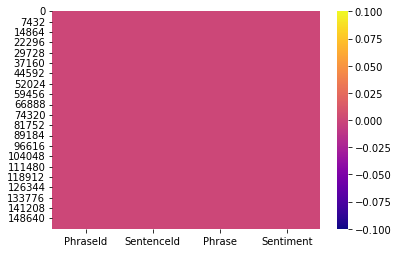

In [19]:
sns.heatmap(train.isnull(),cmap='plasma')

In [20]:
test=test_df.to_pandas()

<AxesSubplot:>

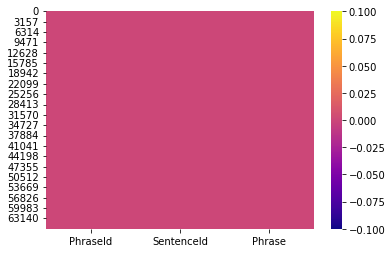

In [21]:
sns.heatmap(test.isnull(),cmap='plasma')

In [22]:
import string
import re
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
#removing punctuations
train['Phrase']=train['Phrase'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)).lower())
#removing punctuations
test['Phrase']=test['Phrase'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)).lower())

In [24]:
#remove html tags
def clean_html(text):
    clean=re.compile('<.*?>')
    return re.sub(clean,'',text)

In [25]:
train['Phrase']=train['Phrase'].apply(clean_html)
test['Phrase']=test['Phrase'].apply(clean_html)

In [26]:
#convert text to lowercase
def convert_lower(text):
    return text.lower()

In [27]:
train['Phrase']=train['Phrase'].apply(convert_lower)
test['Phrase']=test['Phrase'].apply(convert_lower)

In [28]:
#remove special characters
def remove_special(text):
    x=''
    
    for i in text:
        if i.isalnum():
            x=x+i
        else:
            x=x+' '
    return x

In [29]:
train['Phrase']=train['Phrase'].apply(remove_special)
test['Phrase']=test['Phrase'].apply(remove_special)

In [30]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [31]:
#remove stopwords
def remove_stopwords(text):
    x=[]
    for i in text.split():
        
        if i not in stopwords.words('english'):
            x.append(i)
    
    y=x[:]
    x.clear()
    return y

In [32]:
train['Phrase']=train['Phrase'].apply(remove_stopwords)
test['Phrase']=test['Phrase'].apply(remove_stopwords)

In [33]:
ps=PorterStemmer()

In [34]:
y=[]
#stem the words
def stem_words(text):
    for i in text:
        y.append(ps.stem(i))
    z=y[:]
    y.clear()
    return z

In [35]:
train['Phrase']=train['Phrase'].apply(stem_words)
test['Phrase']=test['Phrase'].apply(stem_words)

In [36]:
#join the stem words together
def join_back(list_input):
    return " ".join(list_input)

In [37]:
train['Phrase']=train['Phrase'].apply(join_back)
test['Phrase']=test['Phrase'].apply(join_back)

In [38]:
X_train =train['Phrase']
y_train = train['Sentiment']
tokenize = Tokenizer()
tokenize.fit_on_texts(X_train.values)

In [39]:
X_test = test['Phrase']
X_train = tokenize.texts_to_sequences(X_train)
X_test = tokenize.texts_to_sequences(X_test)

In [40]:
#add padding using pre-method
max_sequence_len = max([len(s.split()) for s in train['Phrase']])
X_train = pad_sequences(X_train, max_sequence_len,padding='pre')
X_test = pad_sequences(X_test, max_sequence_len,padding='pre')

In [41]:
X_train

array([[   0,    0,    0, ...,  622,   15,    8],
       [   0,    0,    0, ..., 5288,   12, 3081],
       [   0,    0,    0, ...,    0,    0,  260],
       ...,
       [   0,    0,    0, ...,    0, 7384, 7385],
       [   0,    0,    0, ...,    0,    0, 7384],
       [   0,    0,    0, ...,    0,    0, 7385]], dtype=int32)

In [42]:
print(X_train.shape)
print(X_test.shape)

(156060, 30)
(66292, 30)


# DEEP LEARNING MODELS

**1)LSTM MODEL**

In [43]:
#LSTM Model
embedding_dimension = 100
input_val = len(tokenize.word_index)+1
model_lstm = Sequential()
model_lstm.add(Embedding(input_val, embedding_dimension, input_length=max_sequence_len))
model_lstm.add(LSTM(units=256, dropout=0.3, recurrent_dropout=0.2 , return_sequences=True))
model_lstm.add(LSTM(units=256, dropout=0.3, recurrent_dropout=0.2 ))
model_lstm.add(Dense(5, activation='softmax'))# 5 as we are required to predict 5 labels-0,1,2,3,4


2022-03-16 14:01:31.247216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 14:01:31.252520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 14:01:31.253146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 14:01:31.254143: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [44]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1187800   
_________________________________________________________________
lstm (LSTM)                  (None, 30, 256)           365568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 2,079,965
Trainable params: 2,079,965
Non-trainable params: 0
_________________________________________________________________


In [45]:
early_stopping = EarlyStopping(min_delta = 0.001,
                               mode = 'max',
                               monitor = 'val_acc',
                               patience = 2)
callback = [early_stopping]

In [46]:
#Compiling the model
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
#Fit the model
history_lstm=model_lstm.fit(X_train, y_train,batch_size=128, epochs=10, verbose=1,callbacks=callback)

2022-03-16 14:01:33.325780: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1220/1220 [==============================] - 351s 284ms/step - loss: 0.9891 - accuracy: 0.6008
Epoch 2/10
1220/1220 [==============================] - 352s 289ms/step - loss: 0.8261 - accuracy: 0.6606
Epoch 3/10
1220/1220 [==============================] - 355s 291ms/step - loss: 0.7741 - accuracy: 0.6793
Epoch 4/10
1220/1220 [==============================] - 363s 298ms/step - loss: 0.7354 - accuracy: 0.6926
Epoch 5/10
1220/1220 [==============================] - 365s 299ms/step - loss: 0.7047 - accuracy: 0.7041
Epoch 6/10
1220/1220 [==============================] - 361s 296ms/step - loss: 0.6809 - accuracy: 0.7120
Epoch 7/10
1220/1220 [==============================] - 356s 292ms/step - loss: 0.6598 - accuracy: 0.7196
Epoch 8/10
1220/1220 [==============================] - 363s 297ms/step - loss: 0.6426 - accuracy: 0.7252
Epoch 9/10
1220/1220 [==============================] - 366s 300ms/step - loss: 0.6266 - accuracy: 0.7302
Epoch 10/10
1220/1220 [=======================

In [48]:
#Saving the model
model_lstm.save('LSTM_Model.h5')

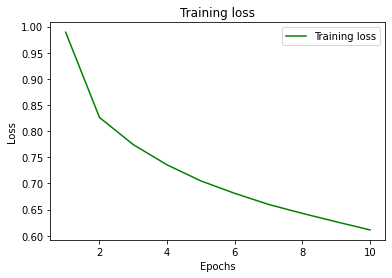

In [49]:
loss_train = history_lstm.history['loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

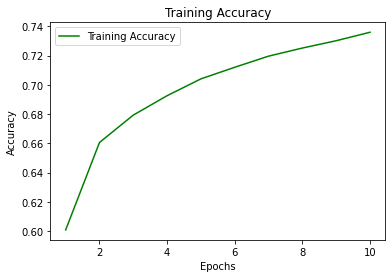

In [50]:
accuracy_train = history_lstm.history['accuracy']
epochs = range(1,11)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
#Predictions on the model
predict_x=model_lstm.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [52]:
classes_x

array([2, 2, 2, ..., 1, 1, 1])

In [53]:
#Submission of all the predictions
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=classes_x
submission_file.to_csv('Submission_LSTM.csv',index=False)

**2)ANN MODEL**

In [54]:
import tensorflow as tf
embedding_dimension = 100
input_val = len(tokenize.word_index)+1
model_ANN = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_val, embedding_dimension, input_length=max_sequence_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [55]:
model_ANN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1187800   
_________________________________________________________________
flatten (Flatten)            (None, 3000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               768256    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 1,957,341
Trainable params: 1,957,341
Non-trainable params: 0
_________________________________________________________________


In [56]:
model_ANN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
history_ANN=model_ANN.fit(X_train, y_train,batch_size=512, epochs=100, verbose=1,callbacks=callback)

Epoch 1/100
305/305 [==============================] - 1s 4ms/step - loss: 1.0182 - accuracy: 0.5906
Epoch 2/100
305/305 [==============================] - 1s 4ms/step - loss: 0.7872 - accuracy: 0.6761
Epoch 3/100
305/305 [==============================] - 1s 4ms/step - loss: 0.7080 - accuracy: 0.7041
Epoch 4/100
305/305 [==============================] - 1s 4ms/step - loss: 0.6605 - accuracy: 0.7196
Epoch 5/100
305/305 [==============================] - 1s 4ms/step - loss: 0.6247 - accuracy: 0.7309
Epoch 6/100
305/305 [==============================] - 1s 4ms/step - loss: 0.5981 - accuracy: 0.7385
Epoch 7/100
305/305 [==============================] - 1s 4ms/step - loss: 0.5746 - accuracy: 0.7461
Epoch 8/100
305/305 [==============================] - 1s 4ms/step - loss: 0.5554 - accuracy: 0.7517
Epoch 9/100
305/305 [==============================] - 1s 4ms/step - loss: 0.5390 - accuracy: 0.7561
Epoch 10/100
305/305 [==============================] - 1s 4ms/step - loss: 0.5244 - accura

In [58]:
model_ANN.save('ANN_Model.h5')

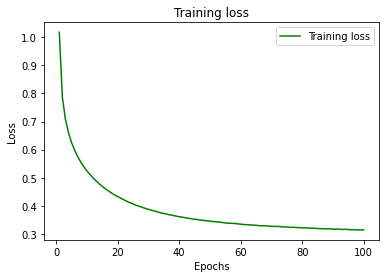

In [59]:
loss_train_ANN = history_ANN.history['loss']
epochs = range(1,101)
plt.plot(epochs, loss_train_ANN, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

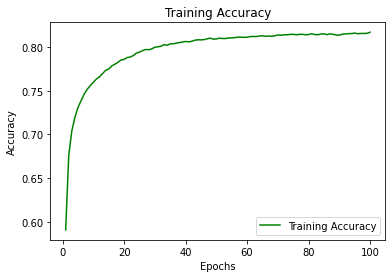

In [60]:
accuracy_train_ANN = history_ANN.history['accuracy']
epochs = range(1,101)
plt.plot(epochs, accuracy_train_ANN, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [61]:
predict_x=model_ANN.predict(X_test) 
classes_x_ANN=np.argmax(predict_x,axis=1)

In [62]:
classes_x_ANN

array([3, 3, 2, ..., 1, 1, 2])

In [63]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=classes_x_ANN
submission_file.to_csv('Submission_ANN.csv',index=False)

**3)CNN MODEL**

In [64]:
import tensorflow as tf
embedding_dimension = 100
input_val = len(tokenize.word_index)+1
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_val, embedding_dimension, input_length=max_sequence_len),
    tf.keras.layers.Conv1D(128, 2, padding='same',activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 2, padding='same',activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [65]:
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           1187800   
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 128)           25728     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 64)            16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)              

In [66]:
model_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
history_CNN=model_CNN.fit(X_train, y_train,batch_size=512, epochs=100, verbose=1,callbacks=callback)

Epoch 1/100


2022-03-16 15:08:02.013073: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


305/305 [==============================] - 8s 7ms/step - loss: 1.1133 - accuracy: 0.5575
Epoch 2/100
305/305 [==============================] - 2s 7ms/step - loss: 0.8557 - accuracy: 0.6511
Epoch 3/100
305/305 [==============================] - 2s 7ms/step - loss: 0.7772 - accuracy: 0.6776
Epoch 4/100
305/305 [==============================] - 2s 7ms/step - loss: 0.7278 - accuracy: 0.6938
Epoch 5/100
305/305 [==============================] - 2s 7ms/step - loss: 0.6954 - accuracy: 0.7048
Epoch 6/100
305/305 [==============================] - 2s 7ms/step - loss: 0.6670 - accuracy: 0.7147
Epoch 7/100
305/305 [==============================] - 2s 7ms/step - loss: 0.6470 - accuracy: 0.7205
Epoch 8/100
305/305 [==============================] - 2s 7ms/step - loss: 0.6276 - accuracy: 0.7273
Epoch 9/100
305/305 [==============================] - 2s 7ms/step - loss: 0.6132 - accuracy: 0.7314
Epoch 10/100
305/305 [==============================] - 2s 8ms/step - loss: 0.6001 - accuracy: 0.7348
E

In [68]:
model_CNN.save('CNN_Model.h5')

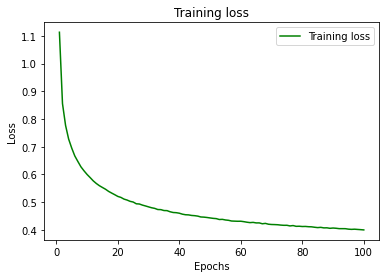

In [69]:
loss_train_CNN = history_CNN.history['loss']
epochs = range(1,101)
plt.plot(epochs, loss_train_CNN, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

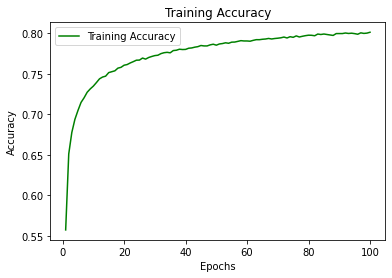

In [70]:
accuracy_train_CNN = history_CNN.history['accuracy']
epochs = range(1,101)
plt.plot(epochs, accuracy_train_CNN, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [71]:
predict_x_CNN=model_CNN.predict(X_test) 
classes_x_CNN=np.argmax(predict_x_CNN,axis=1)

In [72]:
cp.unique(classes_x_CNN)

array([0, 1, 2, 3, 4])

In [73]:
classes_x_CNN

array([1, 1, 2, ..., 1, 1, 1])

In [74]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=classes_x_CNN
submission_file.to_csv('Submission_CNN.csv',index=False)

**4)BI-LSTM MODEL**

In [75]:
import tensorflow as tf
embedding_dimension = 100
input_val = len(tokenize.word_index)+1
model_biLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_val, embedding_dimension, input_length=max_sequence_len),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [76]:
model_biLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           1187800   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [77]:
model_biLSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
history_biLSTM=model_biLSTM.fit(X_train, y_train,batch_size=512, epochs=50, verbose=1,callbacks=callback)

Epoch 1/50
305/305 [==============================] - 15s 24ms/step - loss: 1.1345 - accuracy: 0.5496
Epoch 2/50
305/305 [==============================] - 7s 23ms/step - loss: 0.8785 - accuracy: 0.6452
Epoch 3/50
305/305 [==============================] - 7s 23ms/step - loss: 0.8018 - accuracy: 0.6713
Epoch 4/50
305/305 [==============================] - 7s 23ms/step - loss: 0.7599 - accuracy: 0.6857
Epoch 5/50
305/305 [==============================] - 8s 25ms/step - loss: 0.7278 - accuracy: 0.6962
Epoch 6/50
305/305 [==============================] - 7s 24ms/step - loss: 0.7036 - accuracy: 0.7044
Epoch 7/50
305/305 [==============================] - 7s 23ms/step - loss: 0.6807 - accuracy: 0.7111
Epoch 8/50
305/305 [==============================] - 8s 25ms/step - loss: 0.6626 - accuracy: 0.7176
Epoch 9/50
305/305 [==============================] - 8s 26ms/step - loss: 0.6454 - accuracy: 0.7215
Epoch 10/50
305/305 [==============================] - 7s 23ms/step - loss: 0.6303 - accur

In [79]:
model_biLSTM.save('biLSTM_Model.h5')

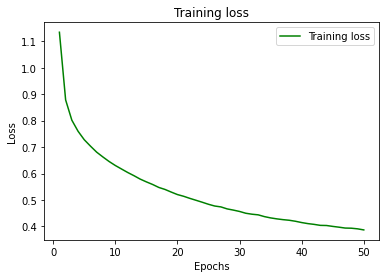

In [80]:
loss_train_biLSTM = history_biLSTM.history['loss']
epochs = range(1,51)
plt.plot(epochs, loss_train_biLSTM, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

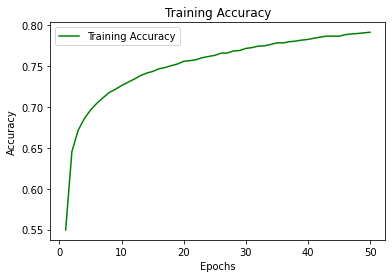

In [81]:
accuracy_train_biLSTM = history_biLSTM.history['accuracy']
epochs = range(1,51)
plt.plot(epochs, accuracy_train_biLSTM, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [82]:
predict_x_biLSTM=model_biLSTM.predict(X_test) 
classes_x_biLSTM=np.argmax(predict_x_biLSTM,axis=1)

In [83]:
classes_x_biLSTM

array([3, 3, 2, ..., 1, 1, 1])

In [84]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=classes_x_biLSTM
submission_file.to_csv('Submission_biLSTM.csv',index=False)

# MACHINE LEARNING MODELS-CUML

**1) Logistic Regression**

In [85]:
#Calling the model
log_reg = OneVsRestClassifier(LogisticRegression())

In [86]:
#Fitting the model
log_reg.fit(X_train.astype('float32'),y_train.astype('float32'))

[W] [15:24:35.632919] L-BFGS: max iterations reached
[W] [15:24:35.633242] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:24:36.371866] L-BFGS: max iterations reached
[W] [15:24:36.372609] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:24:37.194371] L-BFGS: max iterations reached
[W] [15:24:37.195190] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [15:24:37.936051] L-BFGS: max iterations reached
[W] [15:24:37.936568] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

OneVsRestClassifier()

In [87]:
#Making Predictions
y_pred_log_reg = log_reg.predict(X_test.astype('float32'))

In [88]:
y_pred_log_reg=y_pred_log_reg.astype('int32')

In [89]:
y_pred_log_reg

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [90]:
cp.unique(y_pred_log_reg)

array([0, 1, 2, 3, 4], dtype=int32)

In [91]:
#Accurcy score
cu_score_log_reg = cuml.metrics.accuracy_score(y_train, y_pred_log_reg )

In [92]:
cu_score_log_reg

0.5116152763366699

In [93]:
#Creating a submission
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=y_pred_log_reg
submission_file.to_csv('Submission_LogisticRegression.csv',index=False)

**2)Random Forest**

In [94]:
cuml_model = cuRFC(max_features=1.0,
                   n_bins=8,
                   n_estimators=40)

In [95]:
cuml_model.fit(X_train.astype('float32'),y_train.astype('float32'))

RandomForestClassifier()

In [96]:
y_pred_random_forest_classifier = cuml_model.predict(X_test.astype('float32'))

In [97]:
y_pred_random_forest_classifier=y_pred_random_forest_classifier.astype('int32')

In [98]:
y_pred_random_forest_classifier

array([3, 3, 2, ..., 2, 2, 2], dtype=int32)

In [99]:
cp.unique(y_pred_random_forest_classifier)

array([0, 1, 2, 3, 4], dtype=int32)

In [100]:
cu_score_random_forest = cuml.metrics.accuracy_score(y_train, y_pred_random_forest_classifier )

In [101]:
cu_score_random_forest

0.4602515995502472

In [102]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=y_pred_random_forest_classifier
submission_file.to_csv('Submission_RandomForest.csv',index=False)

**3)Naive Bayes**

In [103]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [104]:
nb_predict=nb.predict(X_test)

In [105]:
nb_predict

array([0, 0, 2, ..., 2, 2, 2], dtype=int32)

In [106]:
cp.unique(nb_predict)

array([0, 1, 2, 3, 4], dtype=int32)

In [107]:
cu_score_naive_bayes = cuml.metrics.accuracy_score(y_train, nb_predict )

In [108]:
cu_score_naive_bayes

0.424983412027359

In [109]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=nb_predict
submission_file.to_csv('Submission_NaiveBayes.csv',index=False)

**4)KNeighbors Classifier**

Runtime error in KNN

In [110]:
# from cuml.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(X_train,y_train)

In [111]:

# knn_predict=knn.predict(X_test)

In [112]:
# knn_predict

In [113]:
# cp.unique(knn_predict)

In [114]:
# cu_score_knn = cuml.metrics.accuracy_score(y_train, knn_predict )

In [115]:
# cu_score_knn

In [116]:
# submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
# submission_file['Sentiment']=knn_predict
# submission_file.to_csv('Submission_KNN.csv',index=False)

**5) SVM Classifier**

SVM was taking a very long time to run and was consuming entire RAM, so commented it

In [117]:
# svc_gpu = SVC(kernel='poly', degree=2, gamma='auto', C=1)
# svc_gpu.fit(X_train, y_train)

In [118]:
# svc_gpu_predict=svc_gpu.predict(X_test)

In [119]:
# submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
# submission_file['Sentiment']=svc_gpu_predict
# submission_file.to_csv('Submission_SVM.csv',index=False)

# MACHINE LEARNING MODELS-SKLEARNB

**1)Logistic Regression**

****

In [120]:
#Machine Learning-sklearn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

In [121]:
lr_sklearn = LogisticRegression(random_state=0)

In [122]:
lr_sklearn.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=0)

In [123]:
pred_lr_sklearn=lr_sklearn.predict(X_test)

In [124]:
pred_lr_sklearn

array([2, 2, 2, ..., 2, 2, 2])

In [125]:
np.unique(pred_lr_sklearn)

array([0, 1, 2, 3, 4])

In [126]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=pred_lr_sklearn
submission_file.to_csv('Submission_LogisticRegression_sklearn.csv',index=False)

**2)Random Forest**

In [127]:
rf_sklearn = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=42)

In [128]:
rf_sklearn.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [129]:
rf_sklearn_predict=rf_sklearn.predict(X_test)

In [130]:
rf_sklearn_predict

array([2, 2, 2, ..., 1, 1, 2])

In [131]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=rf_sklearn_predict
submission_file.to_csv('Submission_RandomForest_sklearn.csv',index=False)

**3)Naive Bayes**

In [132]:
nb_sklearn=MultinomialNB()

In [133]:
nb_sklearn.fit(X_train,y_train)

MultinomialNB()

In [134]:
nb_sklearn_predict=nb_sklearn.predict(X_test)

In [135]:
nb_sklearn_predict

array([0, 0, 2, ..., 2, 2, 2], dtype=int32)

In [136]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=nb_sklearn_predict
submission_file.to_csv('Submission_NaiveBayes_sklearn.csv',index=False)

**4)KNeighbors Classifier**

In [137]:
knn_sklearn = KNeighborsClassifier(n_neighbors=3)

In [138]:
knn_sklearn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [139]:
knn_sklearn_predict=knn_sklearn.predict(X_test)

In [140]:
knn_sklearn_predict

array([1, 1, 2, ..., 2, 2, 2])

In [141]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=knn_sklearn_predict
submission_file.to_csv('Submission_KNN_sklearn.csv',index=False)

**5)SVM CLASSIFIER**

SVM was taking a very long time to run and was consuming entire RAM, so commented it

In [142]:
# svc = svm.SVC(decision_function_shape='ovo')
# svc.fit(X_train, y_train)

In [143]:
# svm_pred=svc.predict(X_test)

In [144]:
# submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
# submission_file['Sentiment']=knn_sklearn_predict
# submission_file.to_csv('Submission_KNN_sklearn.csv',index=False)

**6)XGBOOST CLASSIFIER**

In [145]:
xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

In [146]:
xgb.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:13] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_pos_weight", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:48:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=10, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, silent=False,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [147]:
xgb_predict=xgb.predict(X_test)

In [148]:
xgb_predict

array([2, 2, 2, ..., 2, 2, 2])

In [149]:
np.unique(xgb_predict)

array([0, 1, 2, 3, 4])

In [150]:
submission_file =pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
submission_file['Sentiment']=xgb_predict
submission_file.to_csv('Submission_XGB.csv',index=False)